## Taxis Dataset Analysis, PPCA + GMM
___

In [2]:
import matplotlib.pyplot as plt

from advi import *
from advi_models import *

**loading data :**

In [3]:
data = pd.read_csv('Data/interp_taxis_df.csv')

X = data.to_numpy()

data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,y41,y42,y43,y44,y45,y46,y47,y48,y49,y50
0,-8.639910,-8.640217,-8.640874,-8.641003,-8.639363,-8.638067,-8.636489,-8.634915,-8.633835,-8.633412,...,41.161578,41.161573,41.161603,41.161632,41.161475,41.160415,41.159611,41.159539,41.159514,41.159502
1,-8.612901,-8.612988,-8.613652,-8.614325,-8.615057,-8.615998,-8.617031,-8.617751,-8.617911,-8.618180,...,41.161060,41.161692,41.161846,41.161882,41.161887,41.161883,41.161878,41.161836,41.161642,41.161176
2,-8.663877,-8.663856,-8.663826,-8.663792,-8.664398,-8.665539,-8.664329,-8.662391,-8.662323,-8.662311,...,41.217176,41.221311,41.225472,41.229120,41.232750,41.235735,41.238213,41.238375,41.237287,41.237118
3,-8.618067,-8.618843,-8.619707,-8.620671,-8.621040,-8.621206,-8.621136,-8.621117,-8.621087,-8.621022,...,41.159506,41.159818,41.160083,41.160307,41.160413,41.160309,41.160077,41.160059,41.160042,41.160024
4,-8.585658,-8.585649,-8.585779,-8.586167,-8.586228,-8.586504,-8.586973,-8.584766,-8.583280,-8.581663,...,41.091518,41.090989,41.090477,41.090355,41.090357,41.090361,41.090360,41.090364,41.090364,41.090364


___
### I. Probabilistic Principal Component Analysis with Automatic Relevant Determination using Automatic Differentiation Variational Inference

In [4]:
latent_dim = 50
mc_size = 2
n_iter = 500

In [5]:
ppca_ard = PPCA_ARD(X, latent_dim=latent_dim, mc_size=2, max_iter=2000)

ppca_ard.fit(X)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [07:28<00:00,  4.46it/s]


In [6]:
max(ppca_ard.elbo_history())

-3362801.0

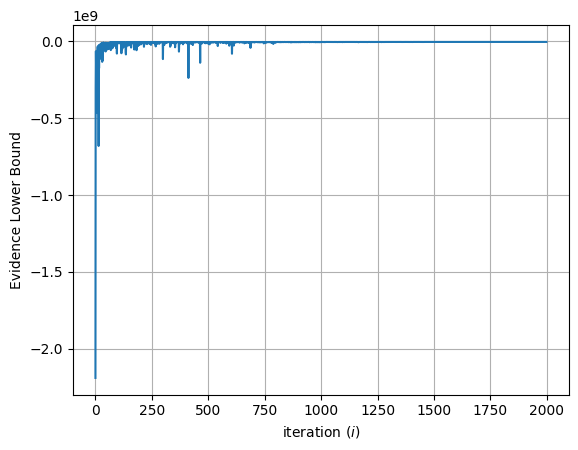

In [7]:
plt.plot(ppca_ard.elbo_history()[1:])
plt.grid()

plt.ylabel('Evidence Lower Bound')
plt.xlabel('iteration $(i)$')
plt.savefig(f'figs/ppca_ard_elbo_mc{mc_size}.png')

**Estimates for $\theta = (w, z, \sigma, \alpha)$ :** 

In [8]:
w, z, sigma, alpha = ppca_ard.theta_estimates(n_estimators=10)

In [9]:
alpha

tensor([[0.1497],
        [0.3113],
        [0.1674],
        [0.1619],
        [0.1831],
        [0.1707],
        [0.1347],
        [0.0983],
        [0.1151],
        [0.1999],
        [0.2872],
        [0.1380],
        [0.1057],
        [0.2337],
        [0.1610],
        [0.2432],
        [0.1049],
        [0.1081],
        [0.0819],
        [0.2883],
        [0.2268],
        [0.2407],
        [0.0398],
        [0.1741],
        [0.1263],
        [0.1401],
        [0.2477],
        [0.1135],
        [0.1926],
        [0.2272],
        [0.2117],
        [0.1837],
        [0.1038],
        [0.1331],
        [0.1625],
        [0.2004],
        [0.2258],
        [0.2093],
        [0.1429],
        [0.3029],
        [0.3062],
        [0.1573],
        [0.1386],
        [0.2631],
        [0.2389],
        [0.2346],
        [0.2764],
        [0.2116],
        [0.0903],
        [0.1324]])

**Estimates for the sampling distribution $\phi=(\mu, \omega)$ :**

In [10]:
mu, omega = ppca_ard.phi_estimates()

**Plotting variability importance values and subspace projection :**

<BarContainer object of 50 artists>

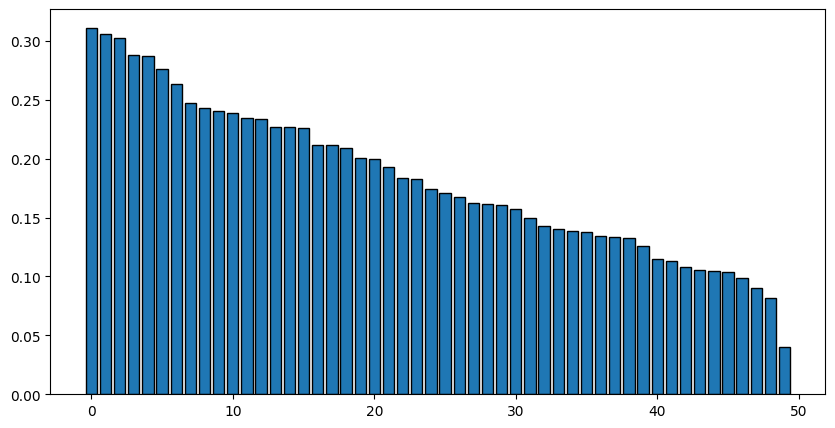

In [11]:
dim_selection = 10

sorted_alpha, sorted_idxs = torch.sort(alpha.squeeze(), descending=True)
idxs = range(len(sorted_alpha))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(idxs,sorted_alpha, edgecolor='black')
#sub_pts = [0, dim_selection, 10]
#ax.plot(sub_pts, [sorted_alpha[i] for i in sub_pts],  marker='.', color='red', linewidth=0.75)

In [12]:
sorted_idxs

tensor([ 1, 40, 39, 19, 10, 46, 43, 26, 15, 21, 44, 45, 13, 29, 20, 36, 30, 47,
        37, 35,  9, 28, 31,  4, 23,  5,  2, 34,  3, 14, 41,  0, 38, 25, 42, 11,
         6, 33, 49, 24,  8, 27, 17, 12, 16, 32,  7, 48, 18, 22])

In [13]:
from sklearn.decomposition import PCA

In [14]:
dim_selection = 2
sorted_alpha, sorted_idxs = torch.sort(alpha.squeeze(), descending=True)
#Xppca = pd.DataFrame(z[:,sorted_idxs[:dim_selection]])
#Xppca

pca = PCA(n_components=11)
Xppca = pca.fit_transform(z)

___
### II. Gaussian Mixture Model for trajectories clustering

In [15]:
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from matplotlib.colors import ListedColormap

In [16]:
cmap = ListedColormap(['blue', 'red'])
cmap.colors

['blue', 'red']

In [17]:
gmm = GaussianMixture(n_components=15, max_iter=1000)

pred = gmm.fit_predict(z)

c:\Users\loren\OneDrive\Documents\M2 MIA\VariationalInference\env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\loren\OneDrive\Documents\M2 MIA\VariationalInference\env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\loren\miniconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\loren\miniconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\loren\miniconda3\Lib\subpro

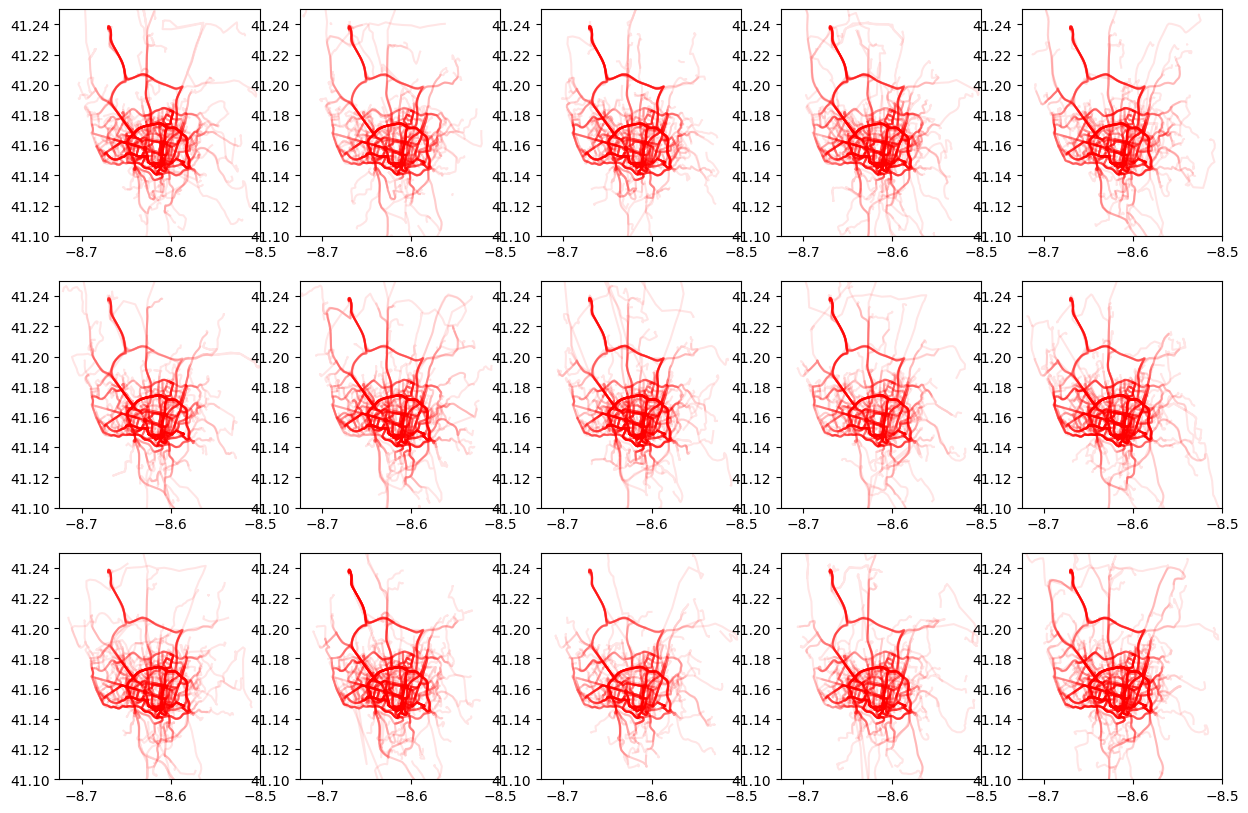

In [18]:
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

for k in range(15):
    i, j = k//5, k%5
    sub = data.loc[pred == k]
    xp = sub.iloc[:,:50].to_numpy()
    yp = sub.iloc[:,50:100].to_numpy()
    for p in range(len(sub)):
        axs[i, j].plot(xp[p], yp[p], color='red', alpha=0.1)

    axs[i, j].set_ylim(41.1, 41.25)
    axs[i, j].set_xlim(-8.725, -8.5)

plt.show()